In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
from keras import models
from keras import layers
from keras import regularizers
from keras.layers import Dense,LSTM
from keras.models import Sequential

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

%matplotlib inline

Using TensorFlow backend.


In [2]:
dfm_series = pd.read_csv('mergeddataseries.csv')
dfm_series = dfm_series.set_index('Date')
dfm_series.head()

,var1(t-20),var2(t-20),var3(t-20),var1(t-19),var2(t-19),var3(t-19),var1(t-18),var2(t-18),var3(t-18),var1(t-17),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var3(t),var2(t),var1(t)
Date,,,,,,,,,,,,,,,,,,,,,
"Jan 25, 1980",1.5074,1.5074,1.5074,1.5076,1.5076,1.5076,1.5081,1.5081,1.5081,1.5149,...,1.5006,1.5035,1.5035,1.5035,1.5026,1.5026,1.5026,1.5004,1.5004,1.5004
"Jan 28, 1980",1.5076,1.5076,1.5076,1.5081,1.5081,1.5081,1.5149,1.5149,1.5149,1.5177,...,1.5035,1.5026,1.5026,1.5026,1.5004,1.5004,1.5004,1.4993,1.4993,1.4993
"Jan 29, 1980",1.5081,1.5081,1.5081,1.5149,1.5149,1.5149,1.5177,1.5177,1.5177,1.5129,...,1.5026,1.5004,1.5004,1.5004,1.4993,1.4993,1.4993,1.4979,1.4979,1.4979
"Jan 30, 1980",1.5149,1.5149,1.5149,1.5177,1.5177,1.5177,1.5129,1.5129,1.5129,1.5168,...,1.5004,1.4993,1.4993,1.4993,1.4979,1.4979,1.4979,1.4986,1.4986,1.4986
"Jan 31, 1980",1.5177,1.5177,1.5177,1.5129,1.5129,1.5129,1.5168,1.5168,1.5168,1.5108,...,1.4993,1.4979,1.4979,1.4979,1.4986,1.4986,1.4986,1.4945,1.4945,1.4945


In [3]:
## create train and test split
n_days = 20
n_features = 3
train = dfm_series.values[:9500, :]
test = dfm_series.values[9500:,:]

#split inputs and output
train_X, train_Y = train[:, :-3], train[:, -1]
test_X, test_Y = test[:, :-3], test[:, -1]

#make the train input 3 dimensional, idk why, think it's required for the lstm
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape )

(9500, 20, 3) (9500,) (565, 20, 3) (565,)


In [4]:
#define model
def build_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
    #model.add(LSTM(128))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

In [5]:
#kfold and fit model
k = 10
num_val_samples = len(train_X) // k
num_epochs = 64
size_batch = 8192
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_X[i * num_val_samples: (i + 1 ) * num_val_samples]
    val_targets = train_Y[i * num_val_samples: (i + 1 ) * num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_X[:i *num_val_samples],
     train_X[(i +1) * num_val_samples: ]],
         axis =0)
    
    partial_train_targets = np.concatenate(
    [train_Y[:i*num_val_samples],
     train_Y[(i + 1) * num_val_samples:]],
         axis = 0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
             epochs= num_epochs, batch_size = size_batch, verbose = 0)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
    all_scores.append(val_mae)
    
#show the average mae
print(sum(all_scores)/len(all_scores))

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9
0.021714655169923054


In [6]:
#Validate with test set
Y_hat = model.predict(test_X)
Y = test_Y

Y_hat_2 = model.predict(train_X)
Y_2 = train_Y

# calculate RMSE
rmse = sqrt(mean_squared_error(Y, Y_hat))
print('Train RMSE: %.3f' % rmse)

# calculate RMSE2
rmse2 = sqrt(mean_squared_error(Y_2, Y_hat_2))
print('Test RMSE2: %.3f' % rmse2)



Train RMSE: 0.015
Test RMSE2: 0.026


<Figure size 432x288 with 0 Axes>

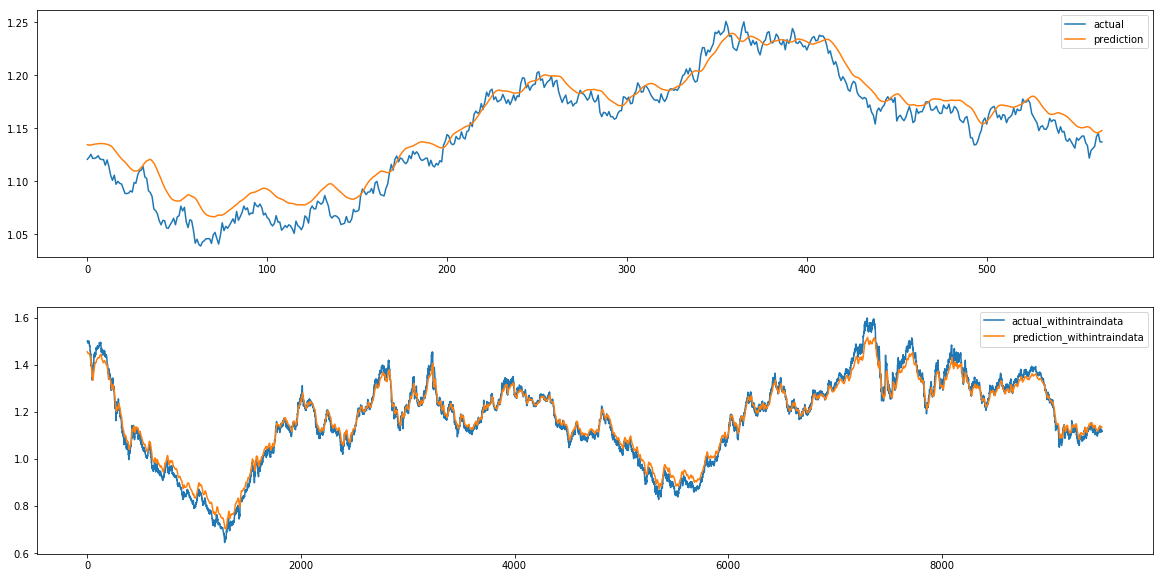

In [7]:
#plot actual stock price and predicted stock price
pyplot.figure(1)
pyplot.figure(figsize=(20,10))

pyplot.subplot(211)
pyplot.plot(Y, label='actual')
pyplot.plot(Y_hat, label='prediction')
pyplot.legend()

pyplot.subplot(212)
pyplot.plot(Y_2, label='actual_withintraindata')
pyplot.plot(Y_hat_2, label = 'prediction_withintraindata')
pyplot.legend()

pyplot.show()

In [8]:
# Notes
# Still looking to add gridsearch for number of days, number of folds, batch size, number of epochs, 
# number of layers? number of neurons in LSTM layers.

# Want to add a plot where the model is used on another forex, to see wheter the model is just overfitted.

# Try the same procedure for a stock where also trade volume can be used (so not a forex).

# Pull the data through a sigmoid function to make it easier for the model to train.


